In [19]:
import numpy as np
from typing import List, Dict, Tuple
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf


class Document:
    def __init__(self, name, embedding, score=-1):
        self.name = name  # First attribute
        self.embedding = embedding  # Second attribute
        self.score = score

class BiasedDocumentMatcher:
    def __init__(self, config: Dict = None):
        # Default configuration
        self.config = {
            "threshold": 0.52,
        }  # Update with user-provided configuration
        if config:
            self.config.update(config)
        self.job = None
        self.resumes = list()
        self.tokenizer = AutoTokenizer.from_pretrained(
            "sentence-transformers/all-MiniLM-L6-v2"
        )
        self.model = TFAutoModel.from_pretrained(
            "sentence-transformers/all-MiniLM-L6-v2"
        )

    def get_sbert_embedding(self, text: str) -> np.ndarray:
        # Tokenize and encode text using BERT's tokenizer with TensorFlow tensors.
        inputs = self.tokenizer(
            text, return_tensors="tf", truncation=True, padding=True
        )
        outputs = self.model(inputs)
        # Mean pool over token embeddings (last_hidden_state shape: [batch_size, seq_len, hidden_size])
        embedding = tf.reduce_mean(outputs.last_hidden_state, axis=1).numpy()[0]
        return embedding

    def set_job(self, job_name, job_text: str):
        self.job = Document(job_name, self.get_sbert_embedding(job_text))

    def remove_job(self):
        self.job = None

    def add_resume(self, resume_name, resume_text: str, score=-1):
        self.resumes.append(
            Document(resume_name, (self.get_sbert_embedding(resume_text)), score)
        )

    def remove_resume(self, idx: int):
        self.resumes.pop(idx)

    def remove_all_resumes(self):
        self.resumes = []

    def calculate_similarity(self, emb1, emb2) -> float:
        similarity = cosine_similarity([emb1], [emb2])[0][0]
        return similarity

    def match_resumes(self):
        scores = []
        for resume in self.resumes:
            score = float(
                self.calculate_similarity(resume.embedding, self.job.embedding)
            )
            # if score > self.config["threshold"]:
            scores.append((score, resume.name, resume.score))

        return scores


In [17]:
import pandas as pd
import os

# Directories containing the files
job_description_folder = './data/job'
resume_folder = 'data/resume'

dfs = []
# Loop through files in the job description folder
for job_description_filename in os.listdir(job_description_folder):
    job_description_path = os.path.join(job_description_folder, job_description_filename)
    dfs.append(pd.read_csv(job_description_path))
job_df = pd.concat(dfs).reset_index(drop=True)
display(job_df.head(5))

resume_df = pd.read_csv(os.path.join(resume_folder, 'fe_resumes.csv'))
display(resume_df.head(5))

,Job Title,Job description
0,interior design,Interior Design Service Specialist - IKEA Bang...
1,interior design,Intermediate Interior Designer\nFull job descr...
2,interior design,Senior Interior Designer\nAbout this role:\nTh...
3,interior design,Interior Designer - Workplace - Mid Level\nFul...
4,interior design,Senior FF&E Designer / FF&E Designer\nFull job...


,Job Title,resume,score
0,Front-end Developer,\nSummary: Experienced Front-End Developer wit...,10
1,Front-end Developer,\nSummary: Front-End Developer with 4 years of...,8
2,Front-end Developer,\nSummary: Entry-level Front-End Developer wit...,6
3,Front-end Developer,\nSummary: Beginner Front-End Developer learni...,4
4,Front-end Developer,\nSummary: Recent high school graduate explori...,2


In [ ]:
# Initialize lists to store precision, recall, F1 scores, and resume scores per iteration
precision_scores = []
recall_scores = []
f1_scores = []
resume_scores = []  # List to track each resume's base score
thresh_hold =  0.52 
print('Using SBERT at threshold: ', thresh_hold)   

matcher = BiasedDocumentMatcher()

for idx, resume in resume_df.iterrows():
    print(f"Index: {idx}, Title: {resume['Job Title']}, Score: {resume['score']}")
    
    matcher.set_job(resume['Job Title'], resume['resume'])
    # Retrieve jobs with similarity above threshold
    res = []
    for index, job in job_df.iterrows():
        matcher.add_resume(job['Job Title'], job['Job description'])
    res = matcher.match_resumes()
    matcher.remove_all_resumes()
    # Filter resumes based on threshold
    res = [item for item in res if item[0] > thresh_hold]   
    # Print the matched resumes     
    res = sorted(res, key=lambda x: x[0], reverse=True)
    print(f"Matched Resumes: ")
    for score, name, _ in res:
        print(f"Name: {name},Score: {score}")

    # Compute precision: correct retrieved / retrieved
    correct = sum(job_title == resume['Job Title'] for _, job_title, _ in res)
    precision = correct / len(res) if res else 0
    print(f'Precision score = {precision}')
    
    # Compute recall: correct retrieved / total relevant items from job_df
    total_relevant = sum(1 for _, job in job_df.iterrows() if job['Job Title'] == resume['Job Title'])
    recall = correct / total_relevant if total_relevant else 0
    print(f'Recall score = {recall}')
    
    # Compute the F1 score for this resume (harmonic mean of precision and recall)
    if precision + recall:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    print(f'F1 score = {f1}')
    
    # Store computed metrics along with the resume's score
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    resume_scores.append(resume['score'])
    
    # Optionally, sort and display the filtered results
    res = sorted(res, key=lambda x: x[0], reverse=True)
    display(res)

# Calculate aggregate (mean) scores over all evaluated resumes
mean_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
mean_recall = sum(recall_scores) / len(recall_scores) if recall_scores else 0
mean_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

print(f"Mean Precision: {mean_precision}")
print(f"Mean Recall: {mean_recall}")
print(f"Mean F1 Score: {mean_f1}")

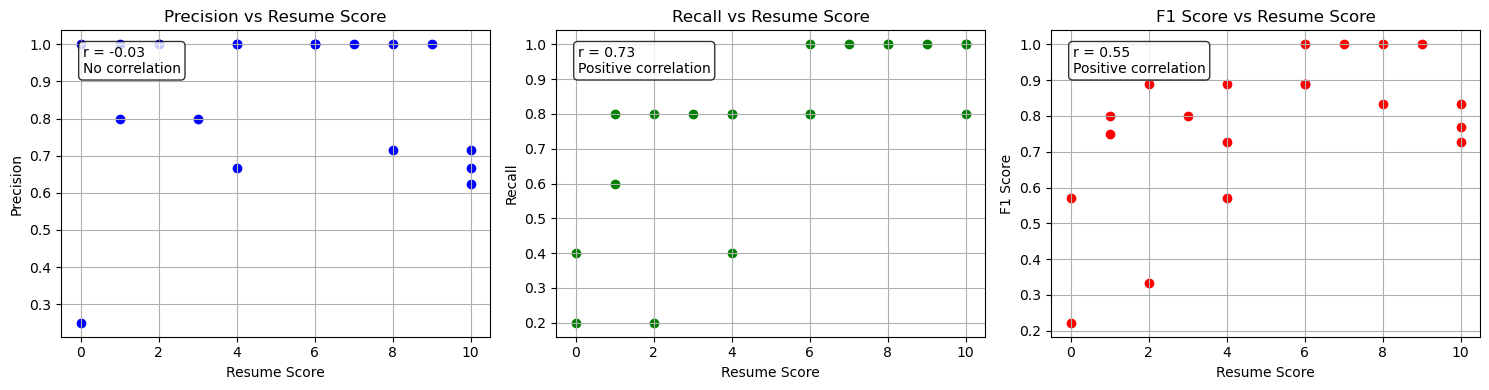

In [ ]:
import matplotlib.pyplot as plt

# Compute correlation coefficients for each metric vs resume score
corr_precision = np.corrcoef(resume_scores, precision_scores)[0, 1]
corr_recall    = np.corrcoef(resume_scores, recall_scores)[0, 1]
corr_f1      = np.corrcoef(resume_scores, f1_scores)[0, 1]

# A helper function to determine the correlation type
def get_correlation_type(corr, threshold=0.05):
    # If abs(corr) is less than threshold, we consider it no correlation
    if abs(corr) < threshold:
        return "No correlation"
    elif corr > 0:
        return "Positive correlation"
    else:
        return "Negative correlation"

# Determine correlation types
corr_type_precision = get_correlation_type(corr_precision)
corr_type_recall = get_correlation_type(corr_recall)
corr_type_f1 = get_correlation_type(corr_f1)

plt.figure(figsize=(15, 4))

# Plot 1: Precision vs Resume Score
plt.subplot(1, 3, 1)
plt.scatter(resume_scores, precision_scores, color='blue')
plt.title('Precision vs Resume Score')
plt.xlabel('Resume Score')
plt.ylabel('Precision')
plt.grid(True)
# Annotate with correlation information
plt.text(0.05, 0.95, f"r = {corr_precision:.2f}\n{corr_type_precision}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 2: Recall vs Resume Score
plt.subplot(1, 3, 2)
plt.scatter(resume_scores, recall_scores, color='green')
plt.title('Recall vs Resume Score')
plt.xlabel('Resume Score')
plt.ylabel('Recall')
plt.grid(True)
# Annotate with correlation information
plt.text(0.05, 0.95, f"r = {corr_recall:.2f}\n{corr_type_recall}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot 3: F1 Score vs Resume Score
plt.subplot(1, 3, 3)
plt.scatter(resume_scores, f1_scores, color='red')
plt.title('F1 Score vs Resume Score')
plt.xlabel('Resume Score')
plt.ylabel('F1 Score')
plt.grid(True)
# Annotate with correlation information
plt.text(0.05, 0.95, f"r = {corr_f1:.2f}\n{corr_type_f1}", transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


## SBERT at 0.52 threshold
- Mean Precision: 0.861845238095238
- Mean Recall: 0.7600000000000001
- Mean F1 Score: 0.7747205572205572
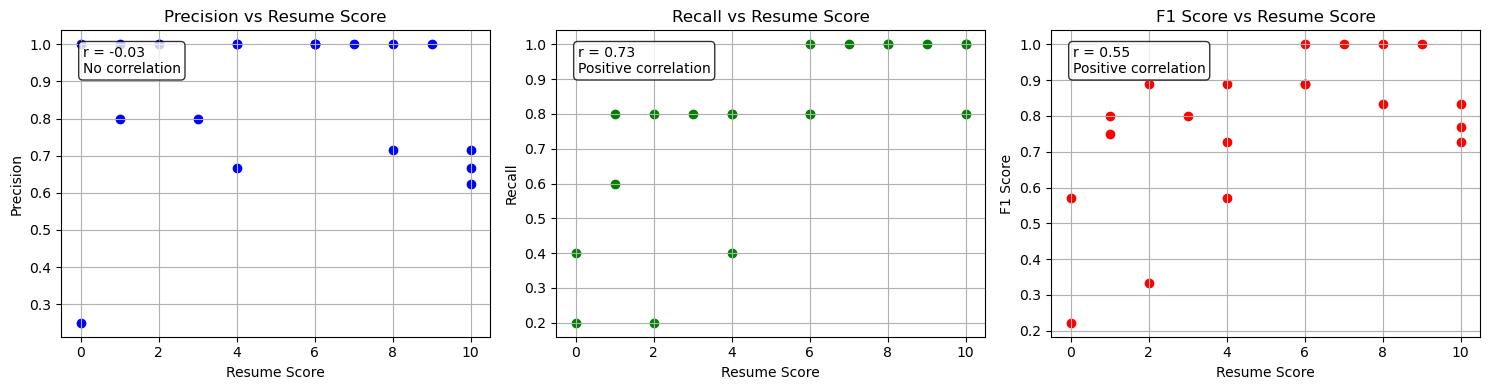
## BOW at 0.25 threshold
- Mean Precision: 0.7193253968253968
- Mean Recall: 0.7
- Mean F1 Score: 0.6828064256005433
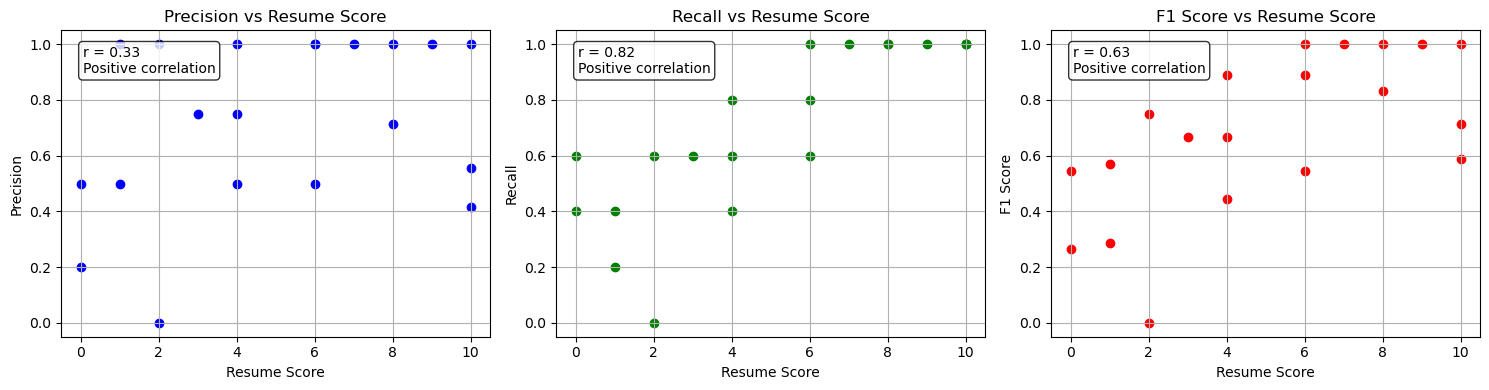

In [23]:
def dcg_at_k(relevances, k):
    """Compute DCG@k for a list of graded relevances."""
    relevances = np.asfarray(relevances)[:k]
    if relevances.size == 0:
        return 0.0
    # DCG formula: first item + discounted sum of rest
    return relevances[0] + np.sum(relevances[1:] / np.log2(np.arange(2, relevances.size + 1)))

def ndcg_at_k(predicted_rels, true_rels, k):
    """
    Compute nDCG@k given:
      - predicted_rels: list of true relevance scores in predicted order
      - true_rels: list of true relevance scores (unsorted)
      - k: cutoff rank
    """
    # DCG of predicted order
    dcg_value = dcg_at_k(predicted_rels, k)
    # DCG of ideal (sorted) order
    ideal_rels = sorted(true_rels, reverse=True)
    idcg_value = dcg_at_k(ideal_rels, k)
    return dcg_value / idcg_value if idcg_value > 0 else 0.0

fe_job_df = job_df[job_df['Job Title'] == 'Front-end Developer']

In [24]:
res

[(0.7590615749359131, 'Front-end Developer', -1),
 (0.6074572801589966, 'Front-end Developer', -1),
 (0.5635848641395569, 'Front-end Developer', -1),
 (0.5501149296760559, 'Front-end Developer', -1),
 (0.5350399017333984, 'UX/UI Designer', -1)]

In [26]:
ndcg_scores = []

Amatcher = BiasedDocumentMatcher()

for job_idx, job in fe_job_df.iterrows():
    # 1. Filter and rank resumes by match_score
    Amatcher.set_job(job['Job Title'], job['Job description'])
    for resume_idx, resume in resume_df.iterrows():
        Amatcher.add_resume(resume['Job Title'], resume['resume'], resume['score'])
    res = Amatcher.match_resumes()
    res = [item for item in res if item[0] > thresh_hold]
    res = sorted(res, key=lambda x: x[0], reverse=True)
    Amatcher.remove_all_resumes()
    
    # 2. Extract the true relevance scores in predicted order
    predicted_true_rels = [true_score for (_, _, true_score ) in res]
    # 3. Extract all true relevance scores for this job (for ideal order)
    all_true_rels = list(resume_df['score'])

    # 4. Compute nDCG@K (K = number of filtered resumes)
    k = len(predicted_true_rels)
    ndcg_score = ndcg_at_k(predicted_true_rels, all_true_rels, k)
    ndcg_scores.append(ndcg_score)
    print(f"Job {job_idx} ({job['Job Title']}): nDCG@{k} = {ndcg_score:.4f}")

    for true_score, name, score in res:
        print(f"Name: {name},Score: {score}, True Score: {true_score}")

mean_nDCG = sum(ndcg_scores) / len(ndcg_scores) if ndcg_scores else 0

print(f"Mean nDCG: {mean_nDCG}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Job 20 (Front-end Developer): nDCG@10 = 0.8961
Name: Front-end Developer,Score: 8, True Score: 0.6764326095581055
Name: Front-end Developer,Score: 6, True Score: 0.6469392776489258
Name: Front-end Developer,Score: 6, True Score: 0.6403180360794067
Name: Front-end Developer,Score: 10, True Score: 0.623718798160553
Name: Front-end Developer,Score: 10, True Score: 0.6218629479408264
Name: Front-end Developer,Score: 10, True Score: 0.6124637722969055
Name: Front-end Developer,Score: 8, True Score: 0.6097413301467896
Name: Front-end Developer,Score: 9, True Score: 0.5789206624031067
Name: Front-end Developer,Score: 6, True Score: 0.5684717297554016
Name: Front-end Developer,Score: 7, True Score: 0.5447013974189758
Job 21 (Front-end Developer): nDCG@17 = 0.8446
Name: Front-end Developer,Score: 6, True Score: 0.7182804942131042
Name: Front-end Developer,Score: 6, True Score: 0.7055965662002563
Name: Front-end Developer,Score: 8, True Score: 0.6924658417701721
Name: Front-end Developer,Score: 